# Topic analysis for Altmetric data

Topic analysis can offer key insights that you can use to improve your research communication plans, strategize patient and reader outreach, and decide where to publish your research.

Here, we do some basic topic analysis on public Facebook Page posts to understand the words and phrases that are most often used in covering a subset of celiac disease research.

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import nltk

nltk.download('punkt') # Includes tokenizers
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
stopw = list(stopwords.words("english"))
# Remove redundant words that are specific to our dataset and don't add value to our analysis
localwords = ['celiac', 'disease', 'pubmed', 'ncbi', 'plos', 'gluten', 'sensitivity']
stopw.extend(localwords)

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /Users/s.konkiel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/s.konkiel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/s.konkiel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load, select, and prepare our data
Let's import data from the Altmetric Explorer mentions tab, which we previously downloaded in CSV format. You can also retrieve this data using the Altmetric Explorer API.

In [104]:
posts = pd.read_csv('./data/mentions_fb_celiac.csv')
posts.head()

,Mention Type,Mention Date,Outlet or Author,Mention Title,Country,External Mention ID,Mention URL,Research Output Title,Journal/Collection Title,Authors at my Institution,...,National Clinical Trial ID,URI,PubMed ID,PubMedCentral ID,Handle.net IDs,ADS Bibcode,arXiv ID,RePEc ID,SSRN,URN
0,Facebook post,2021-01-09 09:19:16,AtaxiaandMe,Myoclonus‐Ataxia Syndromes: A Diagnostic Approach,NaN,NaN,https://www.facebook.com/permalink.php?story_f...,Myoclonus‐Ataxia Syndromes: A Diagnostic Approach,Movement Disorders Clinical Practice,NaN,...,NaN,NaN,33426154,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Facebook post,2020-12-26 15:02:08,Pense Ciência,Photos from Pense Ciência's post,NaN,NaN,https://www.facebook.com/permalink.php?story_f...,Clinical and diagnostic aspects of gluten rela...,World Journal of Clinical Cases,NaN,...,NaN,NaN,25789300,PMC4360499,NaN,NaN,NaN,NaN,NaN,NaN
2,Facebook post,2020-12-26 15:00:47,Pense Ciência,Photos from Pense Ciência's post,NaN,NaN,https://www.facebook.com/permalink.php?story_f...,Clinical and diagnostic aspects of gluten rela...,World Journal of Clinical Cases,NaN,...,NaN,NaN,25789300,PMC4360499,NaN,NaN,NaN,NaN,NaN,NaN
3,Facebook post,2020-12-20 15:34:37,IBS Impact,ACG Clinical Guideline: Management of Irritabl...,NaN,NaN,https://www.facebook.com/permalink.php?story_f...,ACG Clinical Guideline: Management of Irritabl...,American Journal of Gastroenterology,NaN,...,NaN,NaN,33315591,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Facebook post,2020-12-20 12:25:33,IBS Support - Education and Research,ACG Clinical Guideline: Management of Irritabl...,NaN,NaN,https://www.facebook.com/permalink.php?story_f...,ACG Clinical Guideline: Management of Irritabl...,American Journal of Gastroenterology,NaN,...,NaN,NaN,33315591,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
# Let's look specifically at North American public Facebook Page posts
na_posts = posts[posts['Country'].isin(['United States', 'Canada'])]
na_posts = posts[['Mention Date', 'Outlet or Author', 'Mention Title', 'Country',
                 'Mention URL', 'Research Output Title', 'DOI']]
na_posts.head()

,Mention Date,Outlet or Author,Mention Title,Country,Mention URL,Research Output Title,DOI
0,2021-01-09 09:19:16,AtaxiaandMe,Myoclonus‐Ataxia Syndromes: A Diagnostic Approach,NaN,https://www.facebook.com/permalink.php?story_f...,Myoclonus‐Ataxia Syndromes: A Diagnostic Approach,10.1002/mdc3.13106
1,2020-12-26 15:02:08,Pense Ciência,Photos from Pense Ciência's post,NaN,https://www.facebook.com/permalink.php?story_f...,Clinical and diagnostic aspects of gluten rela...,10.12998/wjcc.v3.i3.275
2,2020-12-26 15:00:47,Pense Ciência,Photos from Pense Ciência's post,NaN,https://www.facebook.com/permalink.php?story_f...,Clinical and diagnostic aspects of gluten rela...,10.12998/wjcc.v3.i3.275
3,2020-12-20 15:34:37,IBS Impact,ACG Clinical Guideline: Management of Irritabl...,NaN,https://www.facebook.com/permalink.php?story_f...,ACG Clinical Guideline: Management of Irritabl...,10.14309/ajg.0000000000001036
4,2020-12-20 12:25:33,IBS Support - Education and Research,ACG Clinical Guideline: Management of Irritabl...,NaN,https://www.facebook.com/permalink.php?story_f...,ACG Clinical Guideline: Management of Irritabl...,10.14309/ajg.0000000000001036


In [106]:
# Drop rows without Mention Titles
na_posts_cleaned = na_posts.dropna(subset=['Mention Title'])

# Make all titles lowercase, save to Pandas Series (essentially a list)
posts_set = na_posts_cleaned['Mention Title'].str.lower()

In [107]:
# Split the posts into words ("tokens") and remove stopwords
# Related tutorial: https://pythonhealthcare.org/2018/12/14/101-pre-processing-data-tokenization-stemming-and-removal-of-stop-words/

def tokenize(post):
    try:
        words = nltk.word_tokenize(post)
        token_words = [word for word in words if word.isalpha()] # Remove punctuation
        results = [word for word in token_words if not word in stopw] # Remove stop words 
    except Exception as e:
        print(e)
    
    return results

na_posts_mentions = posts_set.apply(tokenize)
na_posts_mentions.head()

0                    [syndromes, diagnostic, approach]
1                       [photos, pense, ciência, post]
2                       [photos, pense, ciência, post]
3    [acg, clinical, guideline, management, irritab...
4    [acg, clinical, guideline, management, irritab...
Name: Mention Title, dtype: object

In [108]:
# Standardize words into similiar concepts
def lemmatize(post):
    try: 
        words = [lemmatizer.lemmatize(word) for word in post]
        return words
    except Exception as e:
        print(e)

data = na_posts_mentions.apply(lemmatize)

In [109]:
# Create single corpus to analyze
text = [word for post in data.to_list() for word in post]

## Visualizing frequency of words in headlines

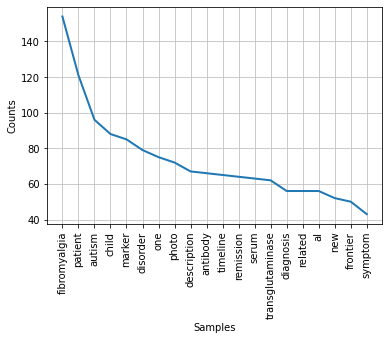

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [171]:
# Single words
freq = nltk.FreqDist(text)
freq.plot(20) # Plot the 20 most common words 

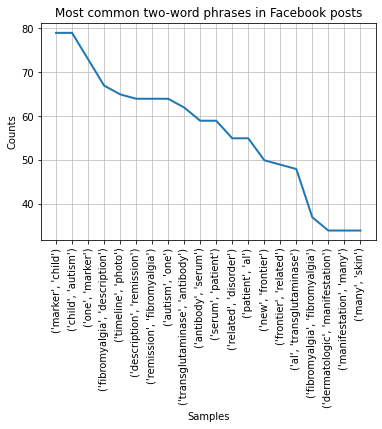

<AxesSubplot:title={'center':'Most common two-word phrases in Facebook posts'}, xlabel='Samples', ylabel='Counts'>

In [172]:
# Two-word phrases ("bigrams")
bigrams = nltk.bigrams(text)
freq_bi = nltk.FreqDist(bigrams)
freq_bi.plot(20, title='Most common two-word phrases in Facebook posts')

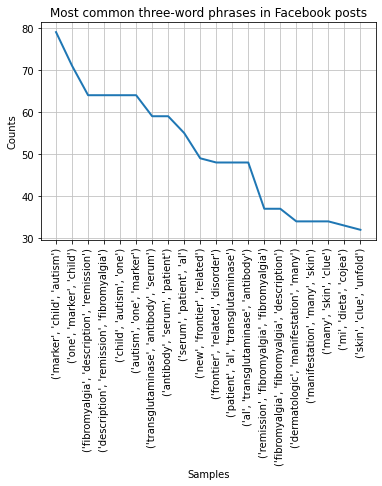

<AxesSubplot:title={'center':'Most common three-word phrases in Facebook posts'}, xlabel='Samples', ylabel='Counts'>

In [120]:
# Three-word phrasees ("trigrams")
trigrams = nltk.trigrams(text)
freq_tri = nltk.FreqDist(trigrams)
freq_tri.plot(20, title='Most common three-word phrases in Facebook posts')

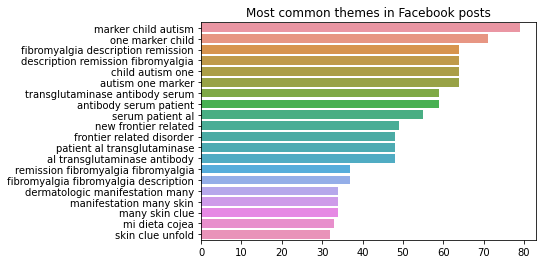

In [173]:
# Finally, we'll restyle our findings so they are nicer to include in reports
# Related tutorial: https://dariuslfuller.medium.com/creating-visuals-with-nltks-freqdist-ac4e667e49f3

trigrams_viz = freq_tri.most_common(20)
trigrams_viz = {' '.join(k):v for k,v in trigrams_viz}

headlines_plot = pd.Series(trigrams_viz)

sns.barplot(x=headlines_plot.values, y=headlines_plot.index)
plt.title('Most common themes in Facebook posts')
plt.show()

## Takeaways
It's clear that North American Facebook interest in celiac disease research focuses a lot on the overlaps with autism and fibromyalgia. These insights could be used to develop communication plans for promoting your research to Facebook users, especially patient advocacy groups and doctors.

## Your turn!
There are many other applications for topic analysis. You could investigate:

* Do Facebook users talk about this research differently than the mainstream media and bloggers do? 
* Do post topics differ based on where in the world research is shared? E.g. Are North Americans talking about this research differently than Europeans on Facebook?
* How do highlighted topics change over time, from one month to the next?
* Do the main topics of social media posts match the topics of the journal articles being shared?